In [1]:
#JV

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

from tqdm.notebook import tqdm

import gc
import os

### Algorithm/Approach:

1. Reset the environment
2. At every step pick an option (from pool of primitive and non-primitive actions, possible in that state - Subject to initial states of that option).
3. Option picked using e-greedy over the Q(S,.).
4. If a non-primitive option is picked, complete it to a termination state, or truncate the episode, which ever happens first. Along the option use greedy wrt Q values to pick the primitive actions.
5. Update Q value of current option after the option ends. [One Step SMDP Qlearning].
6. repeat for multiple episodes till convergence (or max episodes).

gamma = 0.9 is used everywhere.


### Some observations made when I explored the environment:

    1. Dropping off or Picking up at an wrong place would not change the state, but would give a negative reward.
    2. The state is computed as an integer : ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination
        so, the row,col, PAX location and destination could be computed by reversing the above computation.
    3. The Top most row is 0th row and bottom most row is 4th row. Cols are numbered 0 to 4, from left to right.



In [7]:
class OneStepSMDP_Qlearning:

    """
    Provides methods to perform onestep SMDP Qlearning for the "Taxi-v3" environment of Gymnasium
    
    """

    def __init__(self,non_primitive_options=4,initialization = "random",gamma=0.9,seed=76,pick_np_only = False,deterministic_options = 1):

        """
        Default constructor.

        Creates the Taxi-v3 env instance, and sets action, statespace variables.        
        """

        ## set seed
        self.seed = seed
        np.random.seed(self.seed)

        ## create env object
        self.env = gym.make('Taxi-v3')
        self.env.reset(seed=self.seed, options={})
        
        ## set option and state space
        self.non_primitive_options = non_primitive_options
        self.primitive_actions = self.env.action_space.n
        self.option_space = (self.primitive_actions + self.non_primitive_options).astype(int)
        self.state_space = self.env.observation_space.n
        self.pick_np_only = pick_np_only ## if True only non-primitive options would be picked each time.
        self.deterministic_options = deterministic_options

        if self.non_primitive_options == 4:
            ## a dictionary to attach meaning to each non-primitive option
            ## Option 6 (1st non primitive option), is about reaching the designated position 0 (R), similary for the others
            self.options_dict = {
                6 : 0,
                7 : 1,
                8 : 2,
                9 : 3
            }
        elif self.non_primitive_options == 2:
            
            ## a dictionary to attach meaning to each non-primitive option
            ## Option 6 (1st non primitive option), is to pickup the Passenger; passenger location is the third component of the state
            ## Option 7 (second non primitive option), is to drop the passenger; drop location is the fourth component of the state

            self.options_dict = {
                6 : 2,
                7 : 3,
            }
            

        ## create and initialize a Q-Table
        self.initialization = initialization
        self.Initialize_Q_Table(initialization = self.initialization)

        ## Fixing gamma to be 0.9 for all experiments, as specified in PS
        self.gamma = 0.9

        ##creating results dir
        self.base_dir = "SMDP_Q-Learning/"

        if self.non_primitive_options==4:
            self.results_dir = self.base_dir + "Standard_Options/"
        else:
            self.results_dir = self.base_dir + "Custom_Options/"

        self.make_dir(self.base_dir)
        self.make_dir(self.results_dir)

    def make_dir(self,dir):
        try:
            os.mkdir(dir)
        except Exception as e:
            pass
            

    def Initialize_Q_Table(self,initialization = "random"):

        """
        Method to create a Table of size (num_states,num_options) and initialize it as specified.

        Params:
            initialization : "random" (default) or "zeros". Random is uniformly at random between (0,1).

        Returns:
            None.
        """

        if initialization == "zeros":
            
            self.Q = np.zeros((self.state_space,self.option_space))
        
        elif initialization == "random":
        
            self.Q = np.random.random((self.state_space,self.option_space))

    def get_coordinates(self,state):

        """
        Method to compute and return the position (row,col) of the taxi, the location of the passenger and that of the destination.

        Params:
            state : An encoded integer that is used by env to identify the states.

        Returns:
            row[0-4], col[0-4], passenger location[0-4],destination [0-3].
            
        """
    
        dst = state%4
        ploc = (state//4)%5
        col = ((state//4)//5)%5
        row = ((state//4)//5)//5
    
        return row,col,ploc,dst

    def softmax(self,vector):
        
        """
        Method to compute the probabilities proportional to the Q values.
        Vector should be a numpy array.

        Motivation : The evironment, gives an action mask with each state, a bitmap indiacting the actions feasible in that state.

        To experiment with the mask, i.e masking the actions requires making sure that all are non-negative to make sure max/argmax works well.
        Softmax because it directly gives the probabilities.

        Params:
            vector : Specifically the Q values of a particular state.

        Returns:
            softmax (array) of the vector.
        
        """

        max_val = np.max(vector)
        numerator = np.exp(vector-max_val)
        return numerator/np.sum(np.exp(vector-max_val))

    def choose_option(self,state,a_mask,epsilon,use_amask = True):

        """
        Method to pick an option during the epsiode, using e-greedy based on the q-values.
        
        Params:
        
            state : the state in which an option must be picked.
            a_mask : A binary mask provided by the environment to suggest which actions are possible in a given state.
            epsilon : For epsilon greedy
            use_amask : Says if options have to be masked as per a_mask or not.

        Returns:
        
            The chosen option (int).
        """

        if use_amask:
            ## mask for non primitive options
            np_options_mask = np.zeros(self.non_primitive_options)
            
            ## An option can be take if the taxi is not already in the designated position
            if self.non_primitive_options == 4:
                for opt,designated_pos in zip(self.options_dict.keys(),self.options_dict.values()):
                    if not self.env.unwrapped.locs[designated_pos] == self.get_coordinates(state)[:2]:
                        np_options_mask[designated_pos] = 1
            
            ## The mutually exclusive set of options proposed : pickup and drop
            elif self.non_primitive_options == 2:
                passenger_pos = self.get_coordinates(state)[2]
                if passenger_pos == 4: ## passenger in taxi, then pickup option masked
                    np_options_mask[1] = 1
                else: ## drop option masked
                    np_options_mask[0] = 1
                
            ## now put to gether the masks for primitive and non primitice options
            options_mask = np.concatenate((a_mask,np_options_mask))
        else: ## allow all options, no masking.
            options_mask = np.ones(self.option_space) 

        ## to make sure that only the non_primitive(np) options are chosen, not the primitive options
        if self.pick_np_only:
            np_mask = np.concatenate((np.zeros((self.primitive_actions)),np.ones((self.non_primitive_options))))
            options_mask = options_mask*np_mask

        ## do e-greedy
        toss = np.random.random()
        if toss<epsilon: ## explore
            option_probs = options_mask/np.sum(options_mask)
            option = np.random.choice(self.option_space,p=option_probs)
        else: ##exploit
            ## argmax over softmax to make sure that complement of option mask actions are not picked
            option_probs = self.softmax(self.Q[state])*options_mask
            option = np.argmax(option_probs)

        return option

    def choose_primitive_action(self,state,a_mask,epsilon,use_amask):

        """
        Method to pick a primitive action during the during an option. epsilon greedy w.r.t Q values is used.
        This method assists the perform_option method.
        params:
            state : the state in which an option must be picked.
            a_mask : A binary mask provided by the environment to suggest which actions are possible in a given state.
            epsilon : For epsilon greedy
            use_amask : Says if options have to be masked as per a_mask or not.

        Returns:

            A primitive action.
        """

        if not use_amask:
            a_mask = np.ones(self.primitive_actions)

        toss = np.random.random() + self.deterministic_options ## if options are not determinisitic, then deterministic_options = 0 else 1
        if toss<epsilon:
            action_probs = a_mask/np.sum(a_mask)
            action = np.random.choice(list(range(self.primitive_actions)),p=action_probs)
        else:
            ## argmax over softmax to make sure that complement of option mask actions are not picked
            action_probs = self.softmax(self.Q[state][:self.primitive_actions])*a_mask
            action = np.argmax(action_probs)

        return action

    def perform_option(self,state,a_mask,cur_option,step_t,epsilon,eps_decay,eps_end,max_episode_len,use_amask,cutoff=10):

        """
        Method to apply the option to completion (or truncation) from "state" in the environment and return all relevant data.

        Params :

            state : The state in which the option is initiated.
            a_mask : The action mask provided by the environment, along with the state.
            cur_option : The currently initiated option (int).
            step_t : To maintain a global count of the epsiode length. The max episode length of 200 set by the env is respected. Step_t helps if the epsiode has less than 200 steps.
            epsilon : The current value of epsilon used for policy.
            eps_decay : The factor by which the epsilon has to be decayed.
            eps_end : The value at which epsilon stops decaying.
            max_episode_len : The maximum length of any episode. Again, 200 set by env is respected, but this helps when max epsiode length < 200 is required. 
            use_amask : True/False. If False, options are not masked, the agent can choose among all options as per its policy.
            cutoff : The Semi-Markov part :  timeout length at which option is terminated.

        Returns :

            next_state : The next state after the end of the current option.
            a_mask_next : The action mask provided by the env for the next_state.
            tot_reward : The sum of raw rewards obtained during the option (for plotting reward plot).
            disc_reward : The Return (sum of discounted rewards) obtained during the option. Used in SMDP Q update.
            step_t : The current step count in the epsiode, helps resuming.
            done : If the episode has ended/truncated.
            epsilon : The current epsilon value.
            option_duration : The number of steps in the option.
        
        
        """

        
        if cur_option in list(range(self.primitive_actions)):

            next_state, reward, done, truncated, info = self.env.step(cur_option)
            a_mask_next = info['action_mask']
            step_t += 1
            tot_reward = reward
            disc_reward = reward
            epsilon = max(epsilon*eps_decay,eps_end)
            option_duration = 1


        else:

            stop = 0 ## flag variable to control stopping
            option_complete = 0 ## flag to check if the designated state is reached.

            tot_reward = 0
            disc_reward = 0
            option_duration = 0

            designated_pos = self.options_dict[cur_option]

            while not stop:

                cur_action = self.choose_primitive_action(state,a_mask,epsilon,use_amask)
                next_state, reward, done, truncated, info = self.env.step(cur_action)
                a_mask_next = info['action_mask']
                
                tot_reward += reward
                disc_reward += (self.gamma**option_duration)*reward
                
                step_t += 1
                option_duration += 1
                
                state = next_state
                a_mask = a_mask_next

                if not self.deterministic_options:
                    epsilon = max(epsilon*eps_decay,eps_end)

                ##checking if option has completed.

                ##checking if the current state is the designated state
                if self.non_primitive_options == 4:
                    #if not self.env.unwrapped.locs[designated_pos] == self.get_coordinates(state)[:2]:
                    if self.env.unwrapped.locs[designated_pos] == self.get_coordinates(state)[:2]:
                        option_complete = 1

                ## The mutually exclusive set of options proposed : pickup and drop. Checking if its complete
                elif self.non_primitive_options == 2:
                    state_coordinates = self.get_coordinates(state)
                    if (cur_option == 6 and state_coordinates[2]==4) or state_coordinates[:2] == self.env.unwrapped.locs[state_coordinates[self.options_dict[cur_option]]]:
                        option_complete = 1

    
                if done or truncated or step_t>= max_episode_len:
                    done = 1

    
                if done or option_complete or option_duration>=cutoff:
                    stop = 1
                    

        return next_state,a_mask_next,tot_reward,disc_reward,step_t,done,epsilon,option_duration

        

    def train(self,alpha = 0.1,max_episodes=100,max_episode_len = 200,eps_start = 0.6,eps_decay = 0.996,eps_end = 0.01,plotting=True,use_amask=True,option_timeout_cutoff = 10):

        """
        Method to train the agent, i.e to perform one SMDP Q-Learning. (sticking to the Algo sketch given in PS).

        params:
            alpha : The learning rate.
            max_episodes : Maximum number of epiodes to train for.
            max_episode_len : Maximum number of primitive time steps per episode.
            eps_start : The begining value of epsilon.
            eps_end : The cutoff value for epsilon decay.
            eps_decay: The factor by which epsilon has to be decayed.

        Note : Epsilon decays based on global primitive time step; not using separate e-decay for the non primitive options.

        Returns:
        
            None.
        """

        ## Reset and initialize the Q table.
        self.Initialize_Q_Table(initialization=self.initialization)
        
        list_of_episode_wise_rewards = [] ## to store the total (undiscounted) reward accumulated in each episode.
        epsilon = eps_start

        for episode in tqdm(range(max_episodes)):

            
            state,mask_dict = self.env.reset(seed = 76,options={})
            a_mask = mask_dict['action_mask'] ##action mask stating the possible PRIMITIVE actions that might be take in the state.
            
            total_reward = 0
            step_t = 0

            while step_t < max_episode_len:

                ## pick and perform the option
                cur_option = self.choose_option(state,a_mask,epsilon,use_amask) ## pick an option that is possible in the current state.
                next_state,next_a_mask,reward,disc_reward,step_t,done,epsilon,option_duration = self.perform_option(state,a_mask,cur_option,step_t,epsilon,eps_decay,eps_end,max_episode_len,use_amask,cutoff = option_timeout_cutoff) ## its simply env.step if it is a primitive action, else it returns at the end of option.

                ## updating the Q table
                self.Q[state,cur_option] = self.Q[state,cur_option] + alpha*(disc_reward + (self.gamma**option_duration)*np.max(self.Q[next_state]) - self.Q[state,cur_option])
                
                total_reward +=  reward

                state = next_state
                a_mask = next_a_mask
                
            list_of_episode_wise_rewards.append(total_reward)


        if plotting:
            plt.figure()
            plt.plot(list(range(len(list_of_episode_wise_rewards))),list_of_episode_wise_rewards)
            title = self.results_dir.split('/')[0].replace("_"," ")+" With "+self.results_dir.split('/')[1].replace("_"," ")
            plt.title(title)
            plt.xlabel('Episode')
            plt.ylabel('Total Reward')
            plt.savefig(self.results_dir+"0.png")
            plt.show()
            self.visualize_q_values()


    def plot_Q(self,Q, message = "Q plot",plot_name = "1",results_dir=""):
        
        """
        Method to plot the heat map of the Q values and the corresponding policy after training.

        The value visualized in each cell is the maximum of the Q values of all options in that state.

        Params:
            
            Q : The Q values after training.
            message : the title of the plot.
            results_dir : The directory to which results must be stored.
    
        Returns : 
            
            None
        """

        plt.figure(figsize=(7,7))
        plt.title(message)
        Q_to_plot = np.flipud(Q) ## flip the Q values array upside Down so that origin is at top left corner
        plt.pcolor(Q_to_plot.max(-1), edgecolors='k', linewidths=2)
        plt.colorbar()
        
        xlabels = [i for i in range(5)]
        ylabels = [i for i in range(5,-1,-1)]
        
        plt.xticks(np.arange(len(xlabels)),xlabels)
        plt.yticks(np.arange(len(ylabels)),ylabels)
    
        plt.savefig(results_dir+plot_name+".png")
        
        plt.show()
        plt.clf()
        plt.close('all')
        gc.collect()

    def visualize_q_values(self):

        """
        Method to visualize Q values as heatmaps, by generating plots for each passenger source-destination pairs.

        Params:
            None.

        Returns:
            None.
        """

        passenger_locs = list(range(5))
        destination_locs = list(range(4))

        loc_label_dict = {

            0 : "R",
            1 : "G",
            2 : "Y",
            3 : "B",
            4 : "Taxi"
        }
        
        plot_id = 1
        
        for ploc in passenger_locs:
            for dloc in destination_locs:
                
                passenger_loc = ploc
                destination = dloc

                ##to store the Q values corresponding to the given passenger-destination locations
                Q_viz = np.zeros((5,5,agent.option_space))
                
                for i in range(5):
                    for j in range(5):
                        state_q_vals = agent.env.unwrapped.encode(i,j,passenger_loc,destination)
                        Q_viz[i,j] = agent.Q[state_q_vals]

                if self.non_primitive_options == 4:
                    options_type = "Standard Options\n"
                else:
                    options_type = "Custom Options\n"

                message = "SMDP Q-Learning With " + options_type +"Q-Values Heatmap when Passenger at "+loc_label_dict[passenger_loc]+" Destination at "+loc_label_dict[destination]+"."
                plot_name = str(plot_id)
                
                self.plot_Q(Q_viz,message,plot_name,self.results_dir)

                plot_id += 1

    

        
        

  0%|          | 0/14000 [00:00<?, ?it/s]

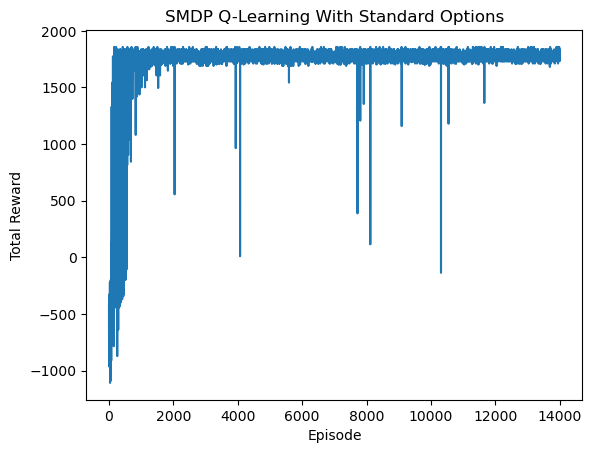

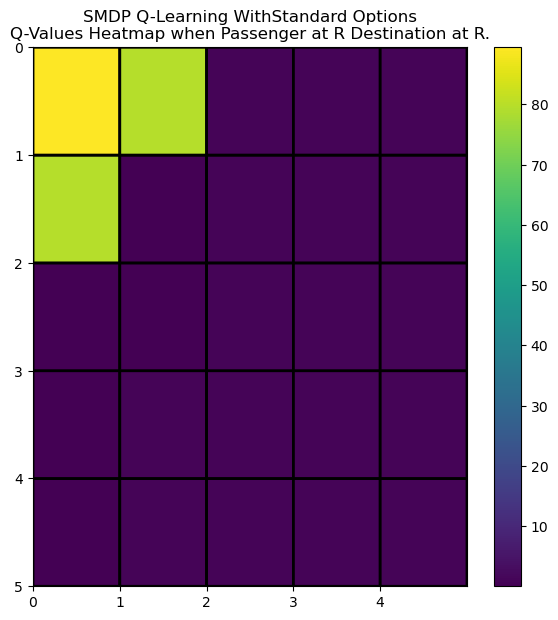

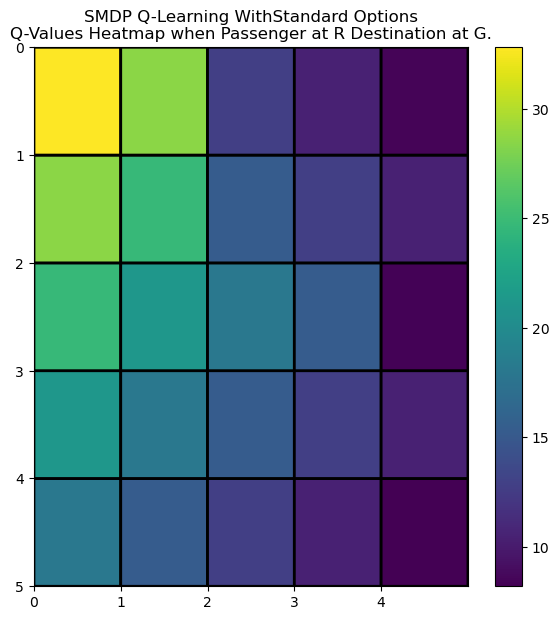

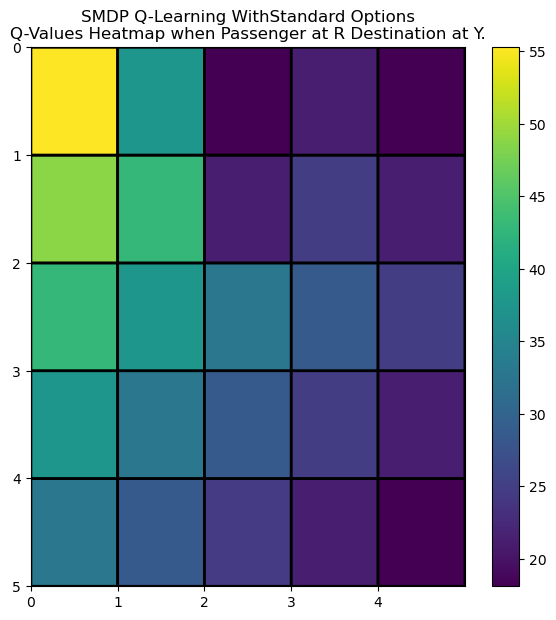

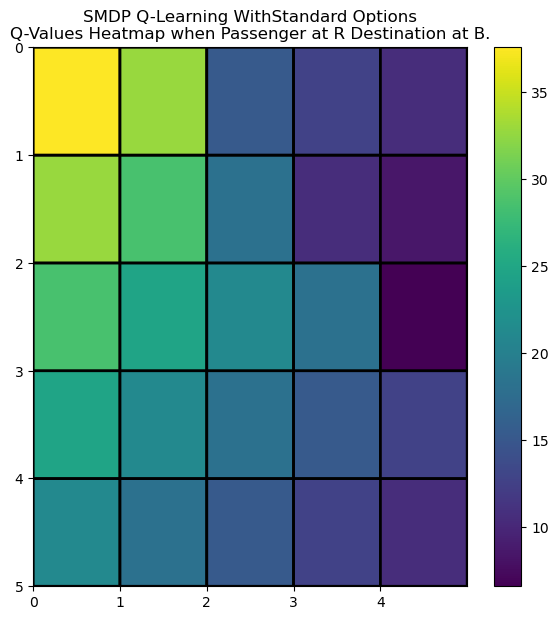

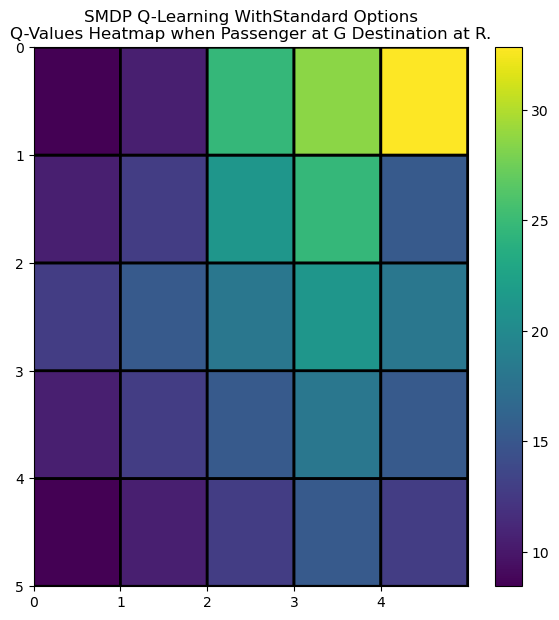

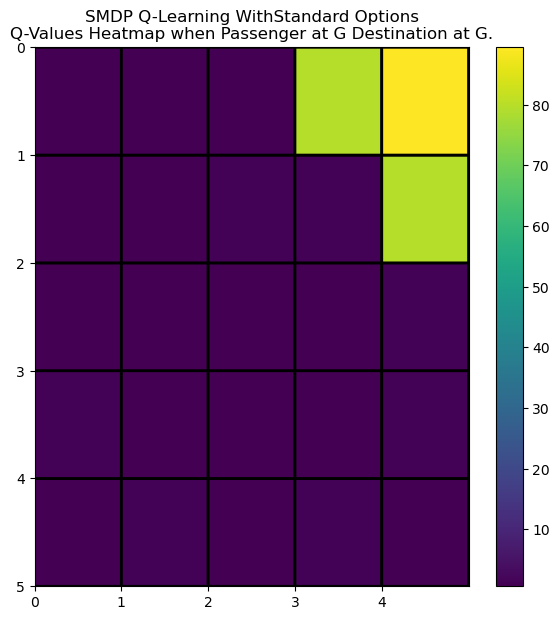

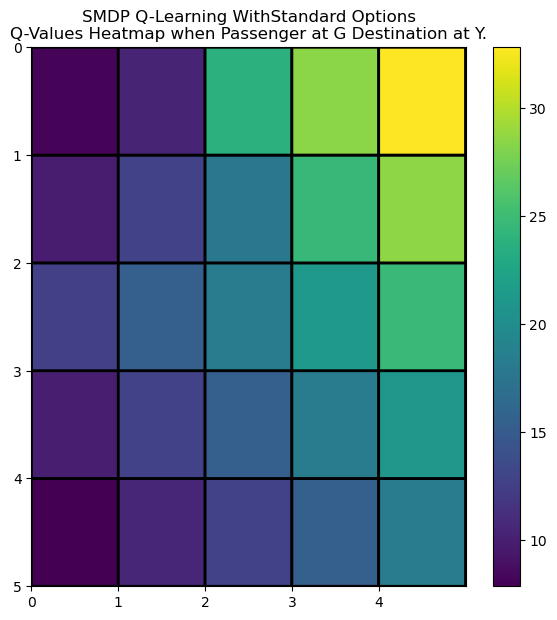

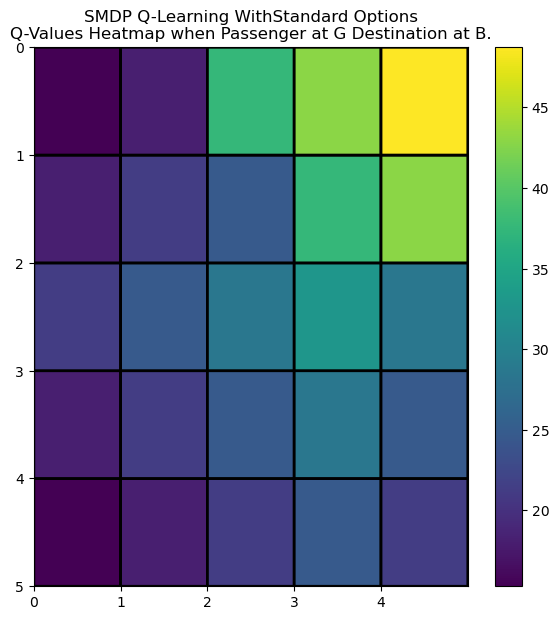

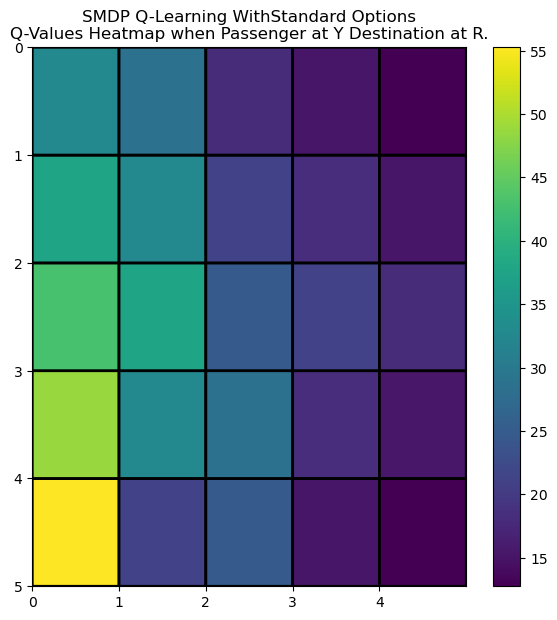

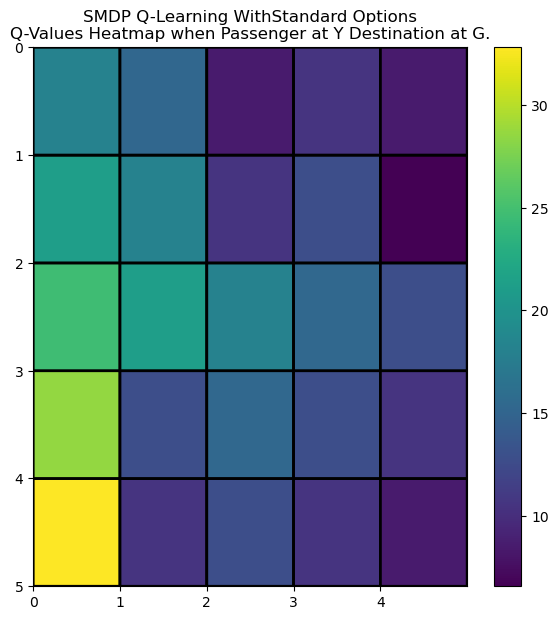

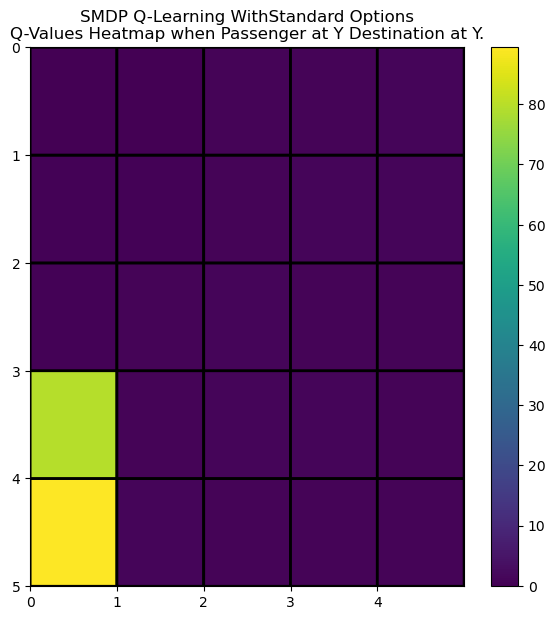

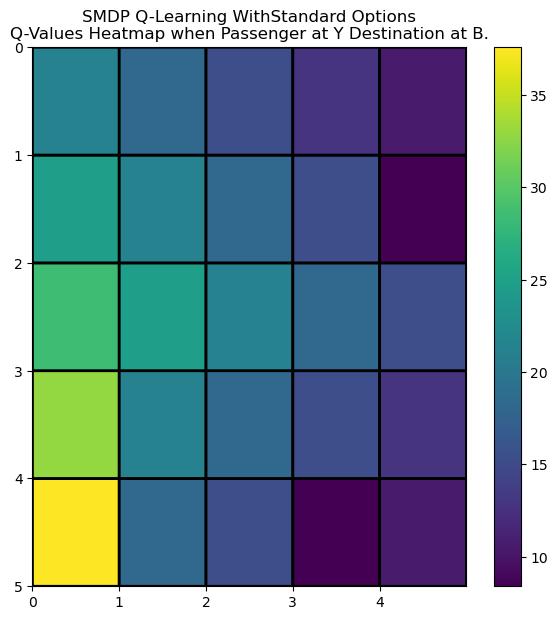

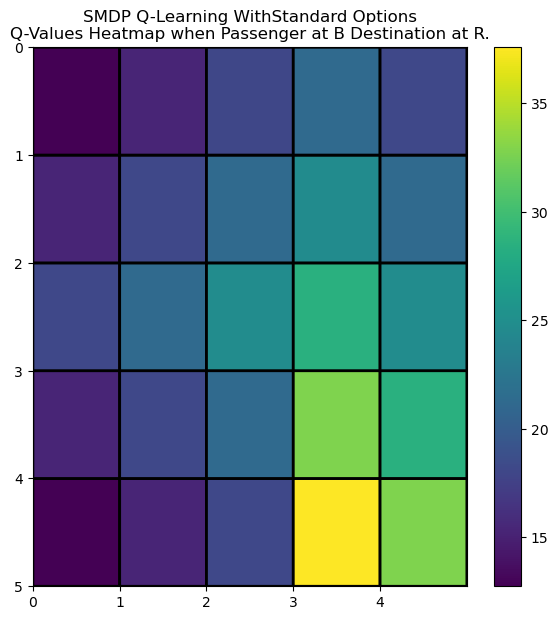

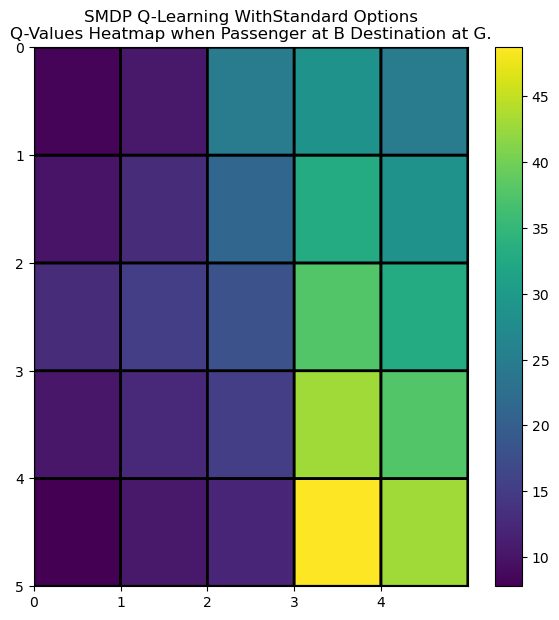

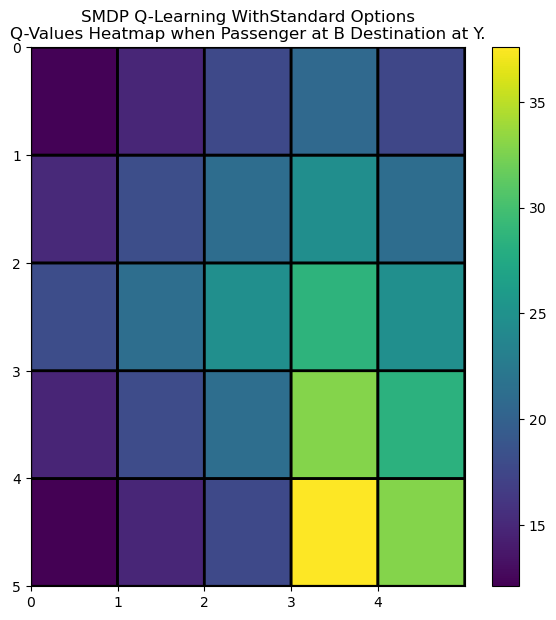

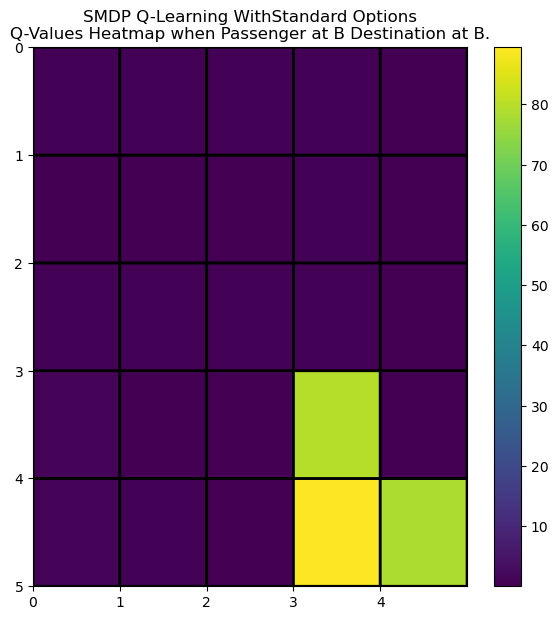

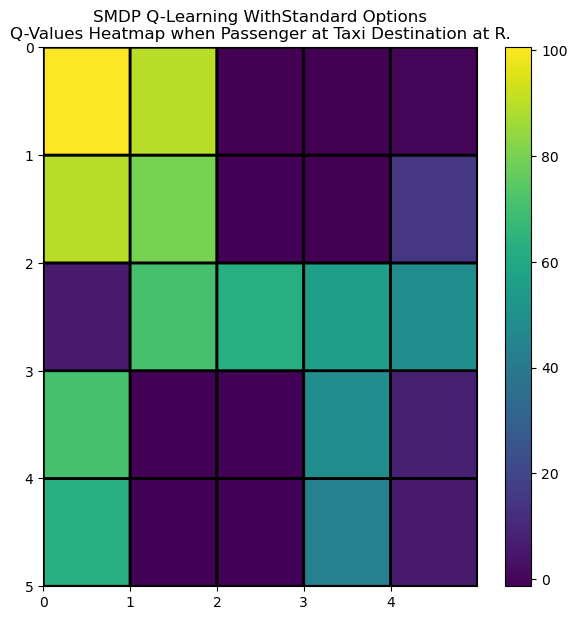

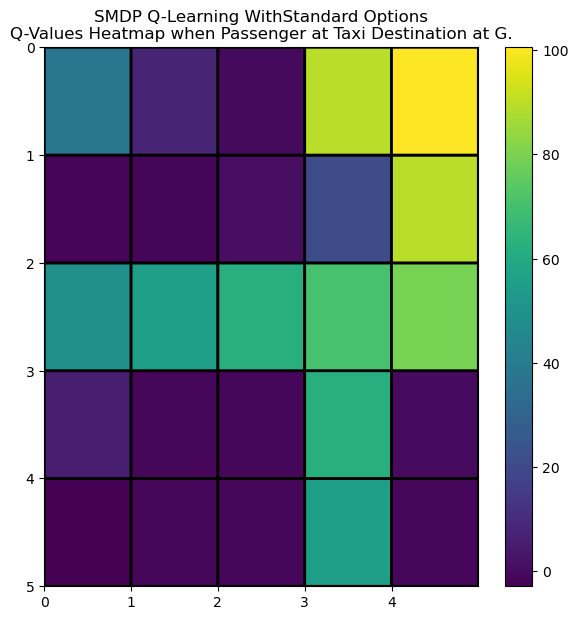

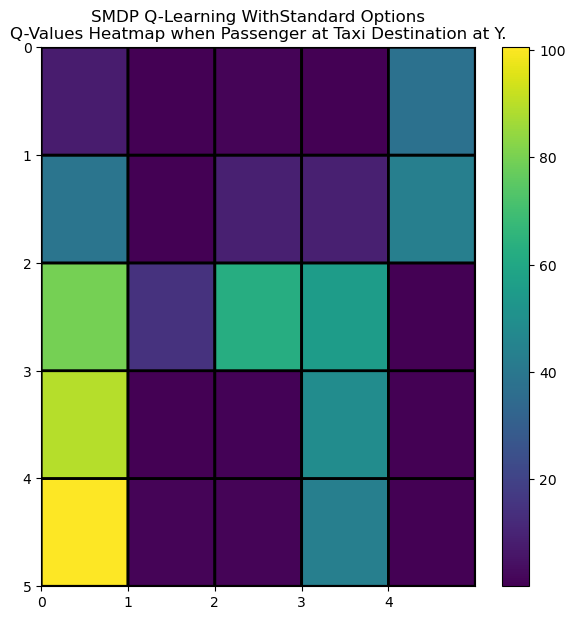

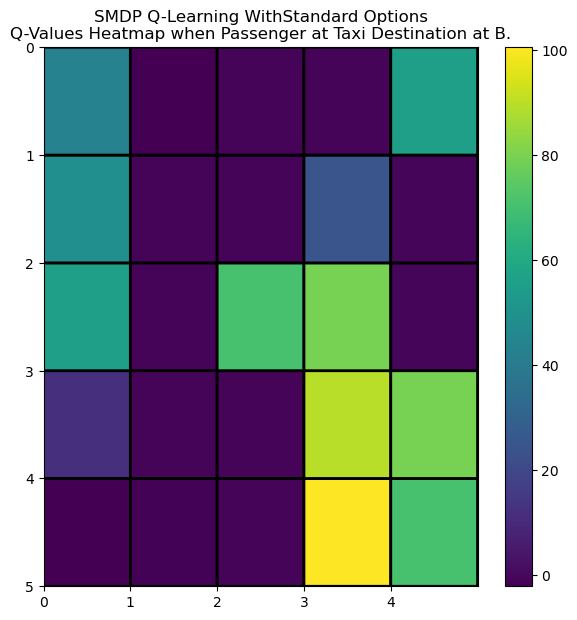

In [4]:
## Train for Standard Options
seed = 76
non_primitive_options = 4
initialization = "random"
pick_np_only = False
deterministic_options = 1

agent = OneStepSMDP_Qlearning(initialization=initialization,non_primitive_options=non_primitive_options,seed=seed,pick_np_only = pick_np_only,deterministic_options=deterministic_options)
agent.train(alpha = 0.2,max_episodes=14000,max_episode_len = 200,eps_start = 0.25,eps_decay = 0.995,eps_end = 0.001,plotting=True,use_amask=False,option_timeout_cutoff=9)


  0%|          | 0/14000 [00:00<?, ?it/s]

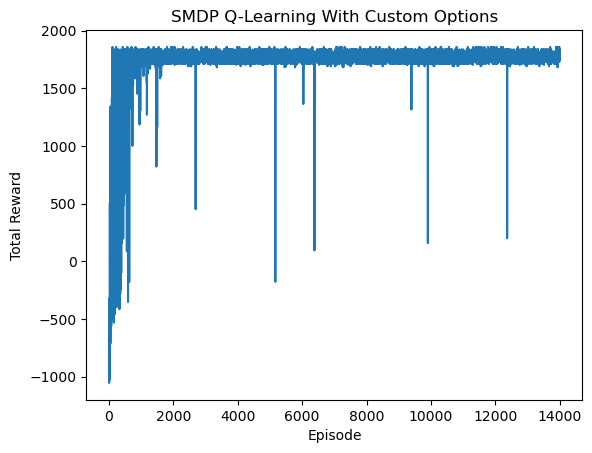

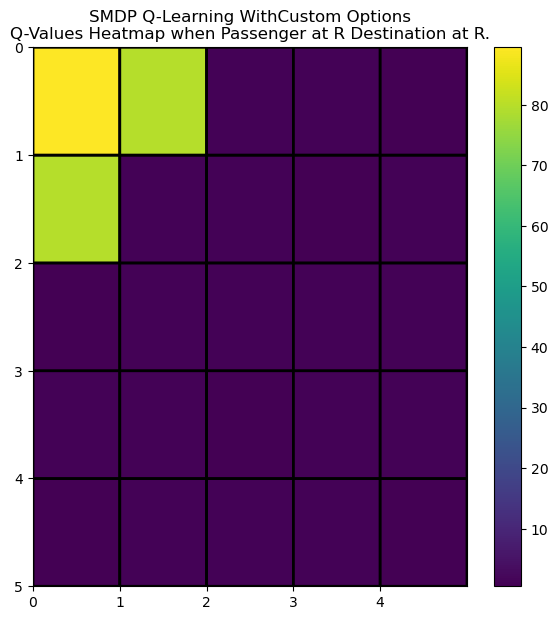

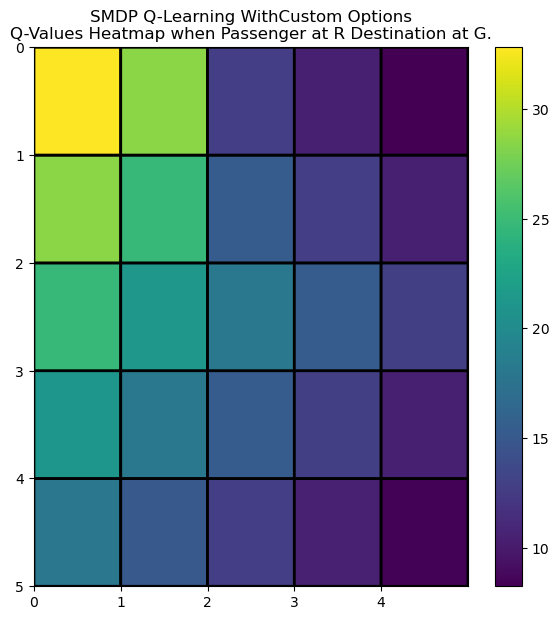

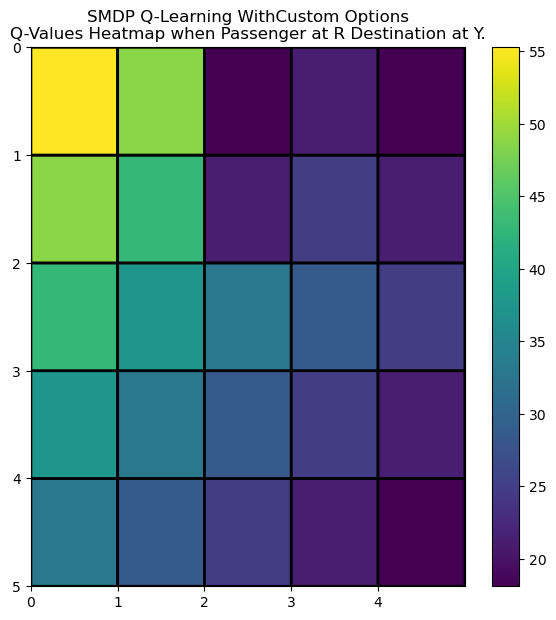

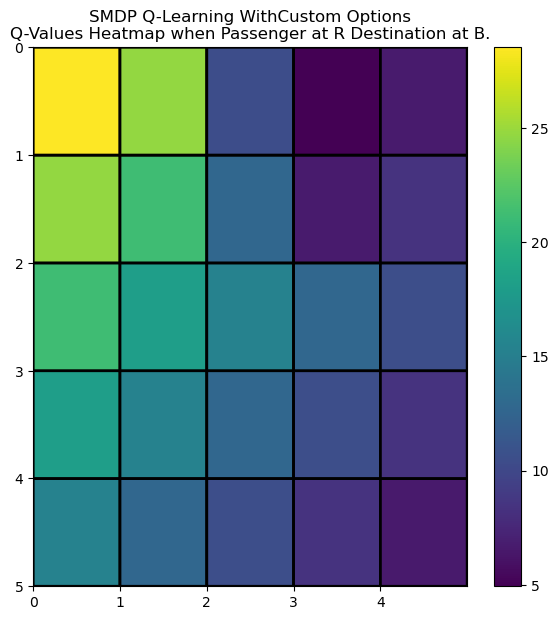

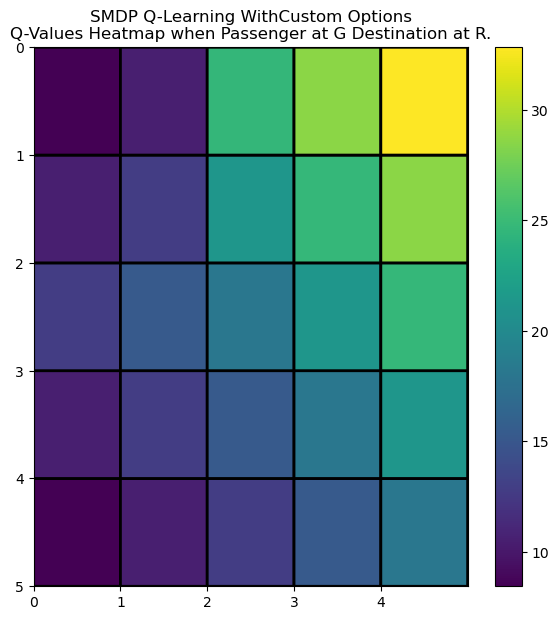

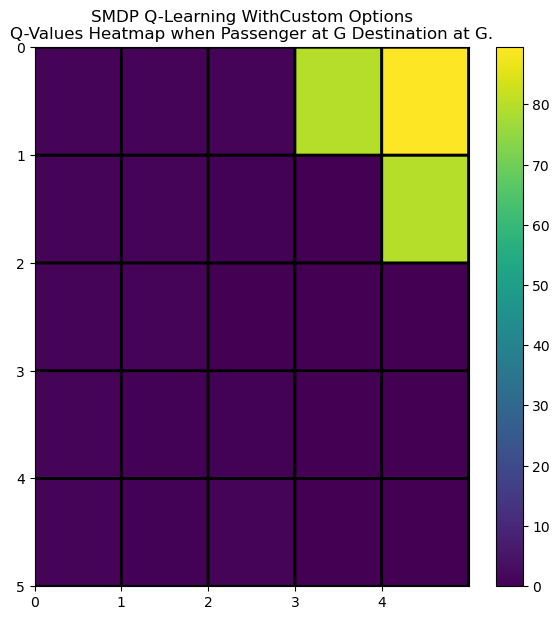

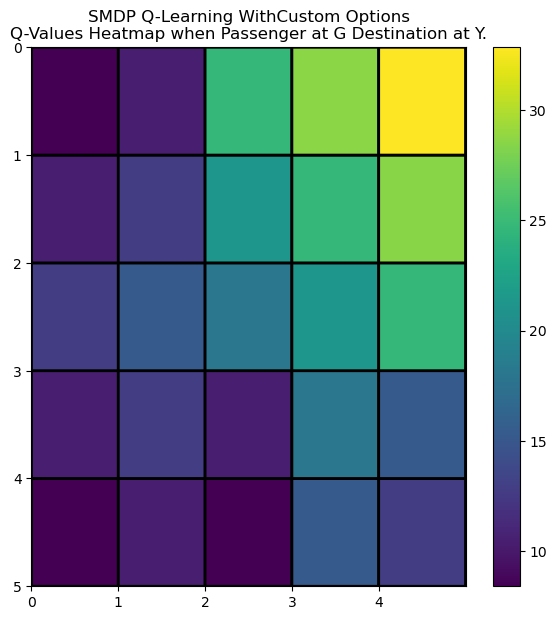

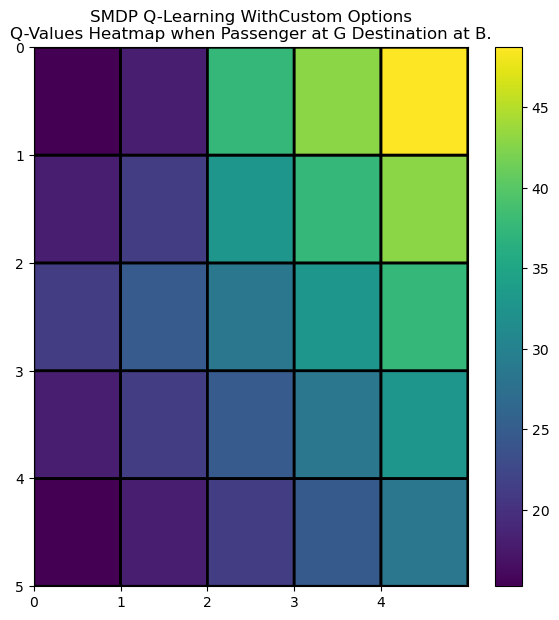

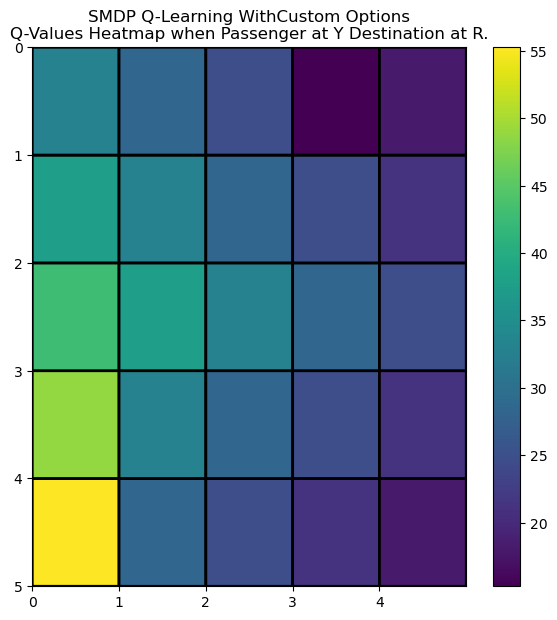

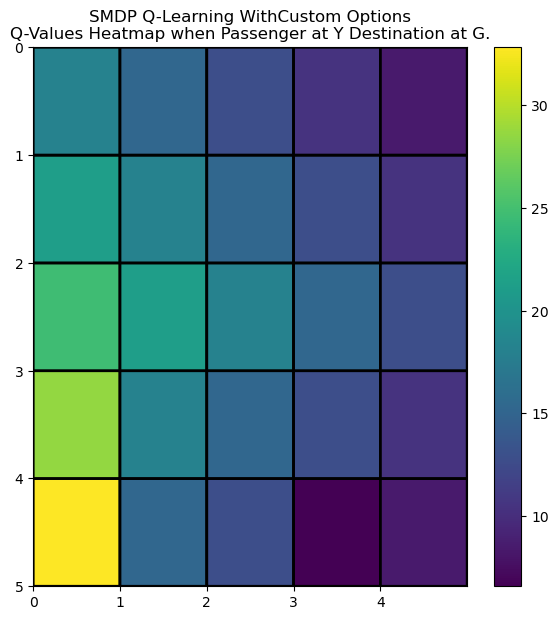

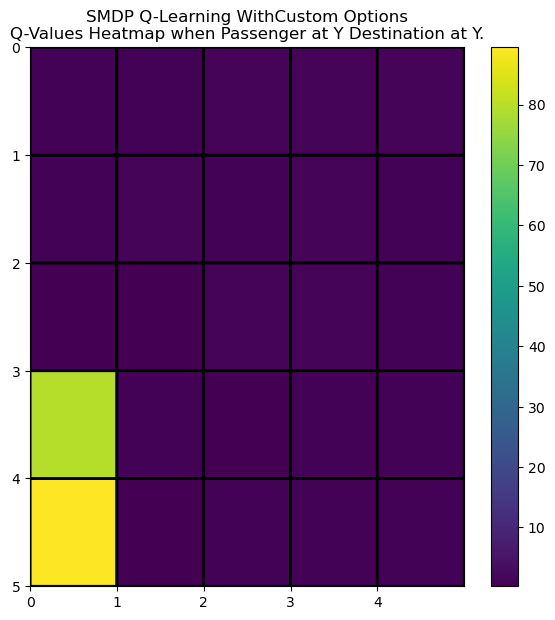

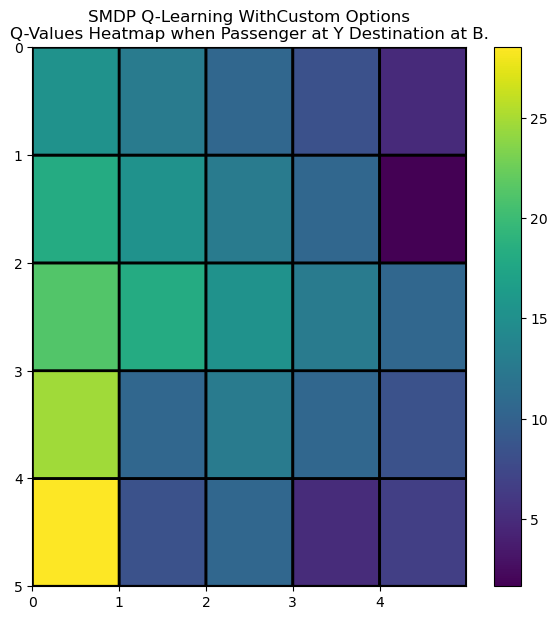

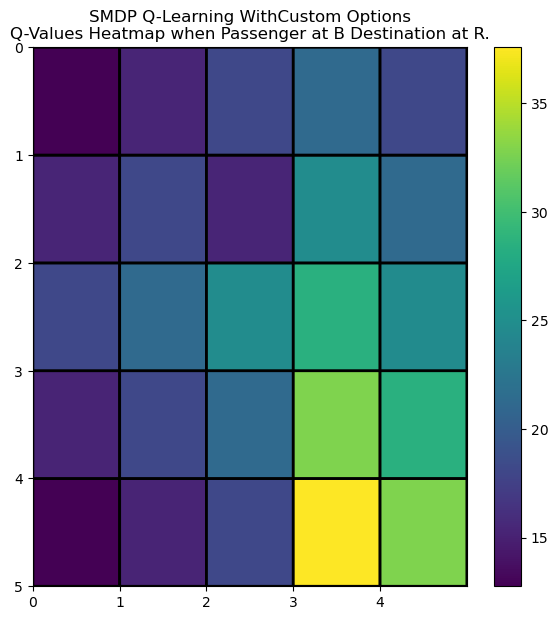

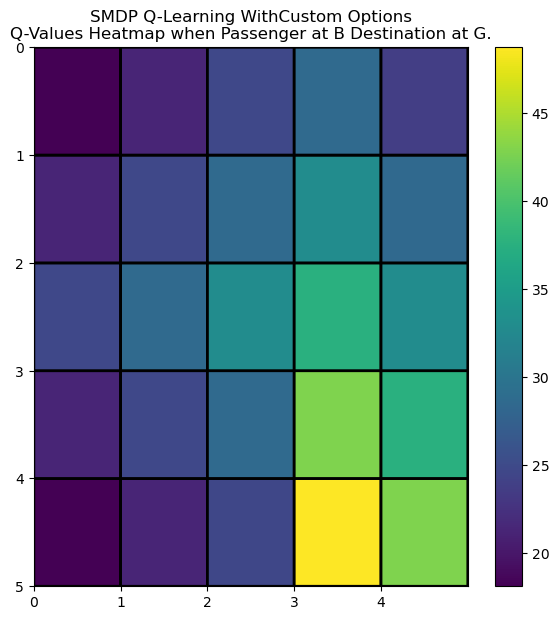

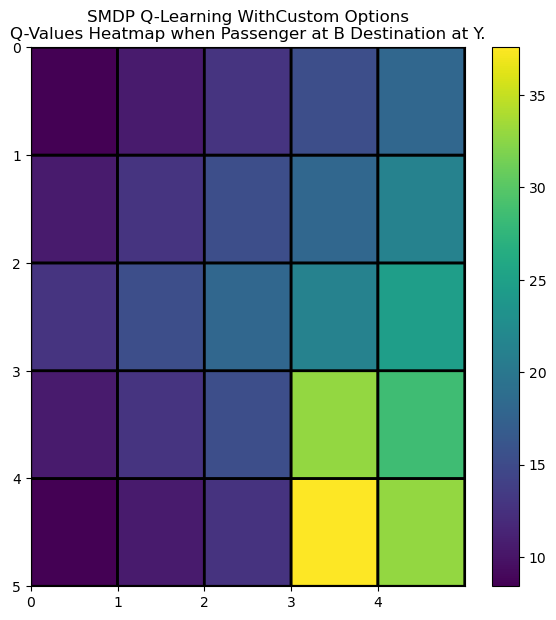

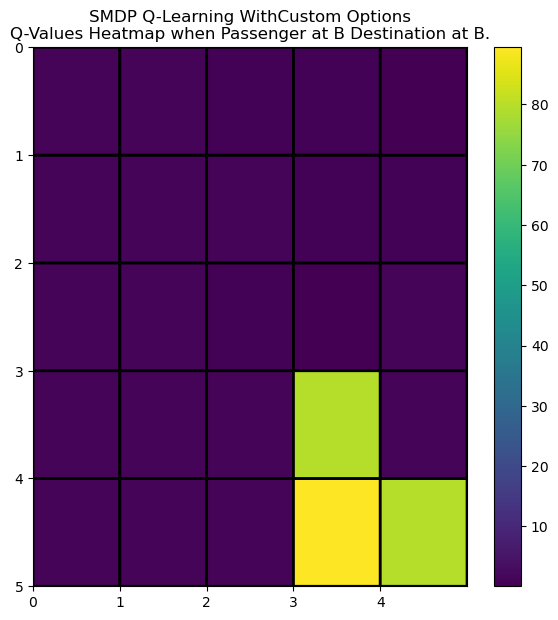

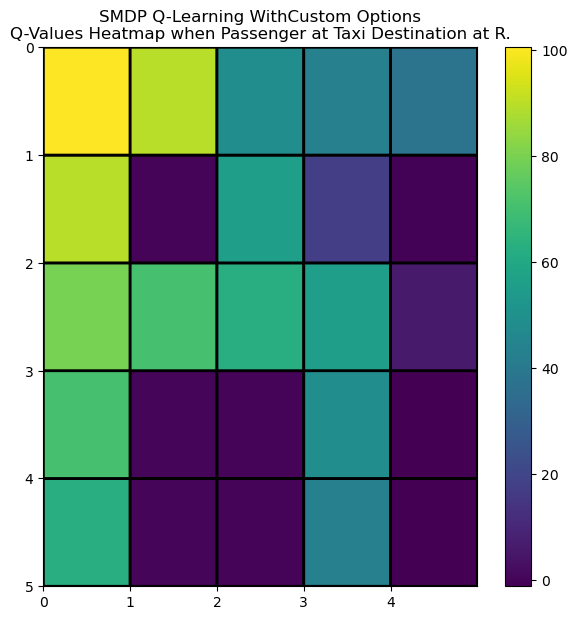

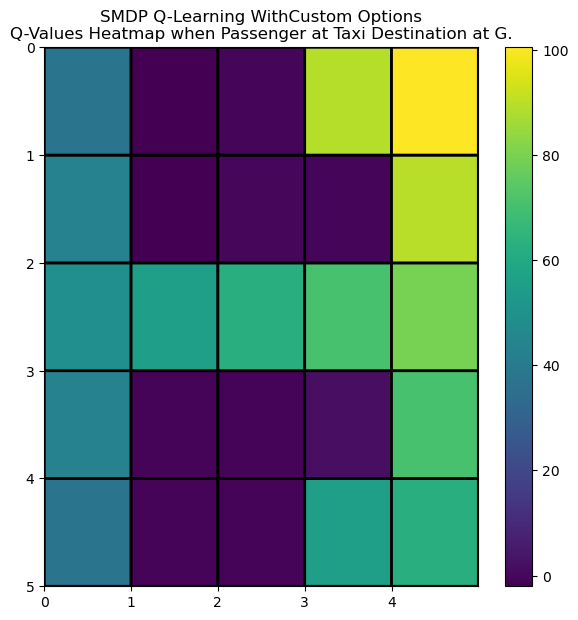

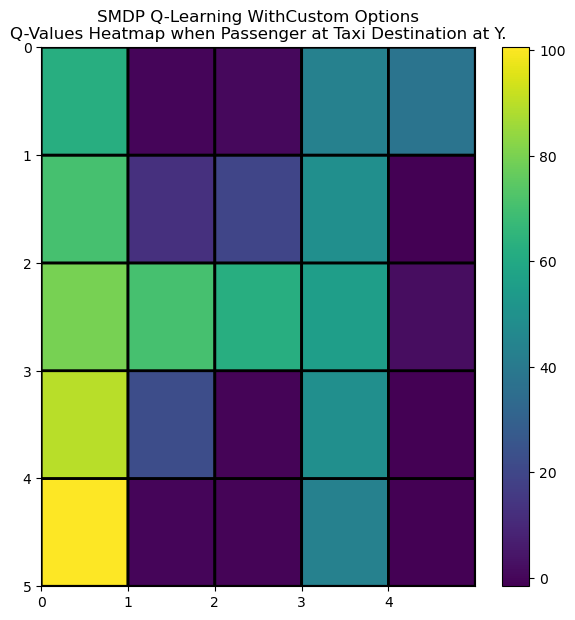

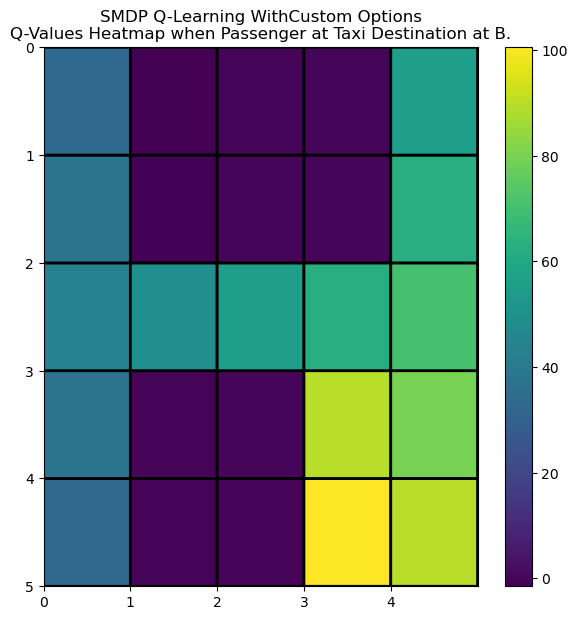

In [5]:
## Train for Custom Options
seed = 76
non_primitive_options = 2
initialization = "random"
pick_np_only = False
deterministic_options = 1

agent = OneStepSMDP_Qlearning(initialization=initialization,non_primitive_options=non_primitive_options,seed=seed,pick_np_only = pick_np_only,deterministic_options=deterministic_options)
agent.train(alpha = 0.2,max_episodes=14000,max_episode_len = 200,eps_start = 0.25,eps_decay = 0.995,eps_end = 0.001,plotting=True,use_amask=False,option_timeout_cutoff=9)


  0%|          | 0/200 [00:00<?, ?it/s]

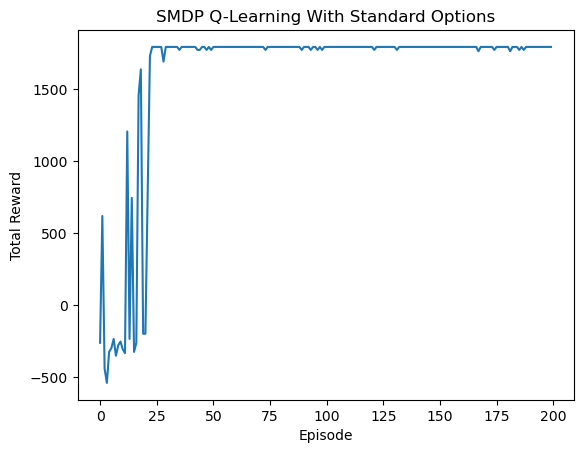

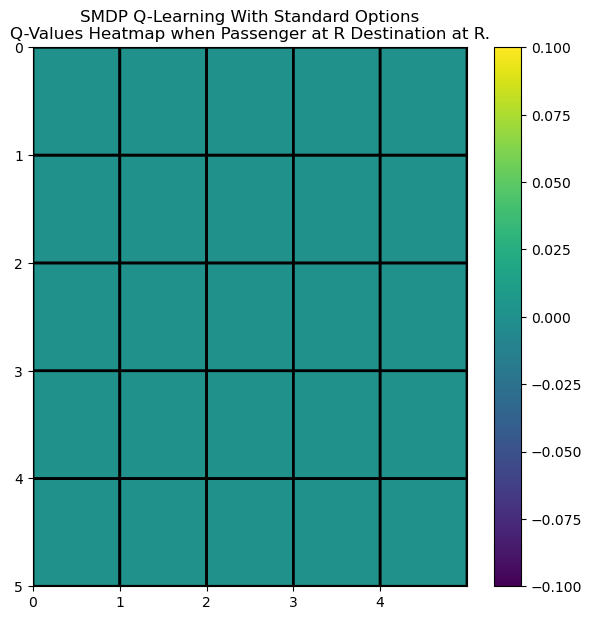

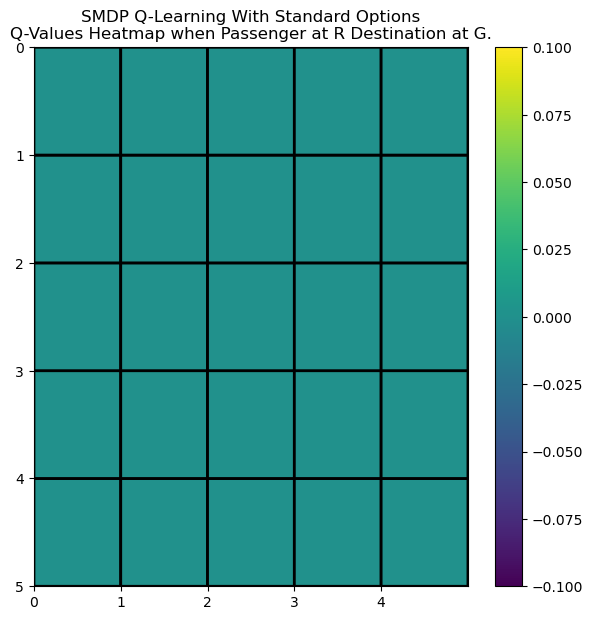

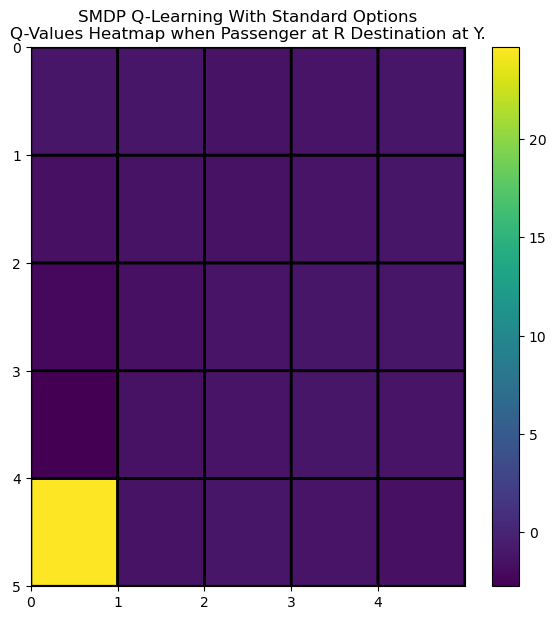

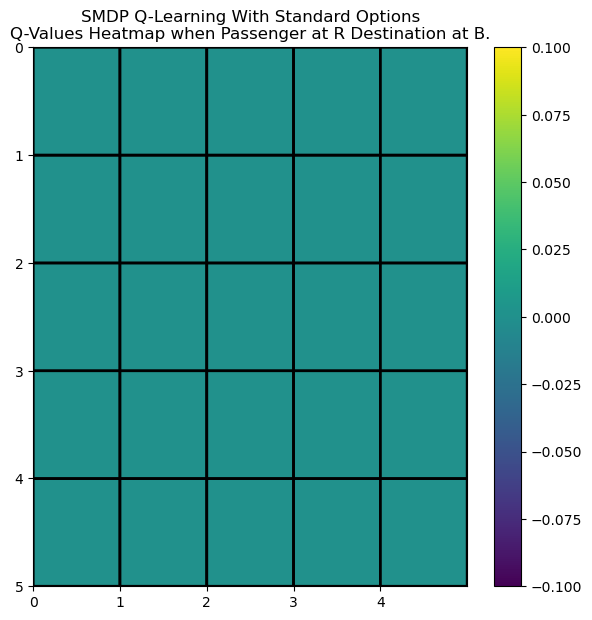

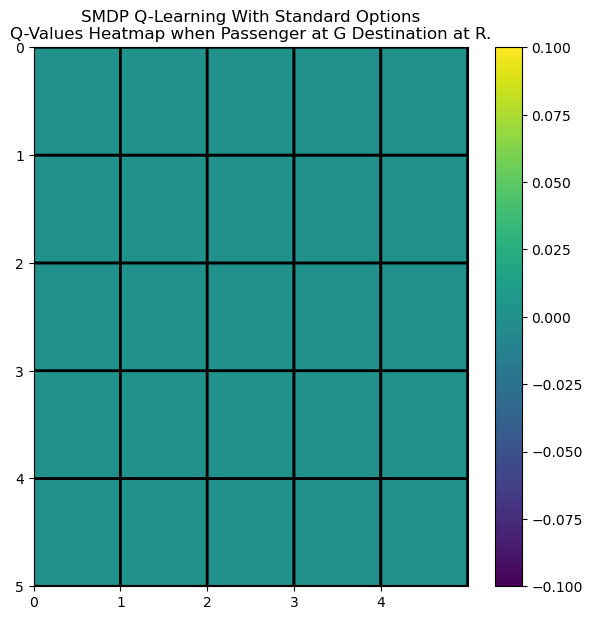

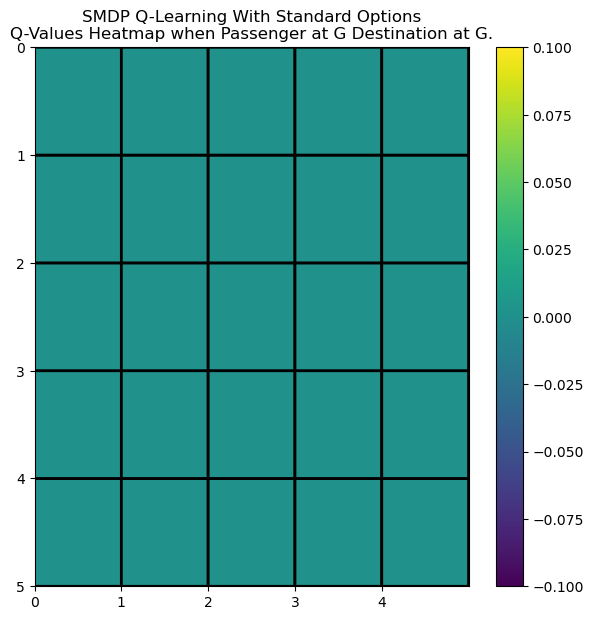

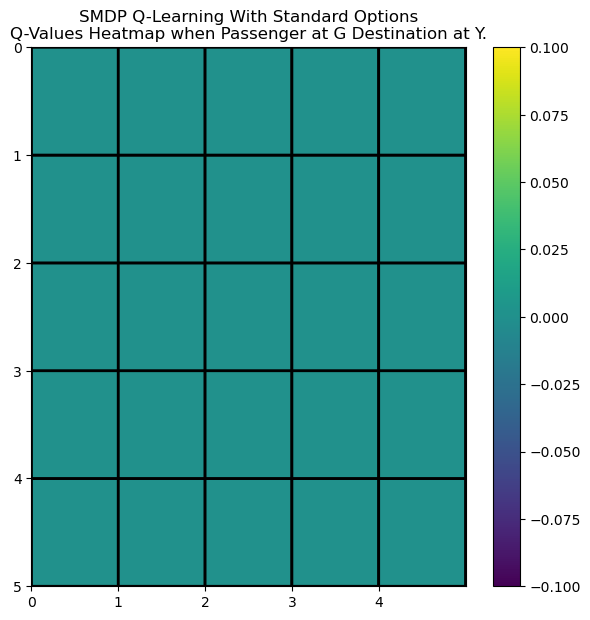

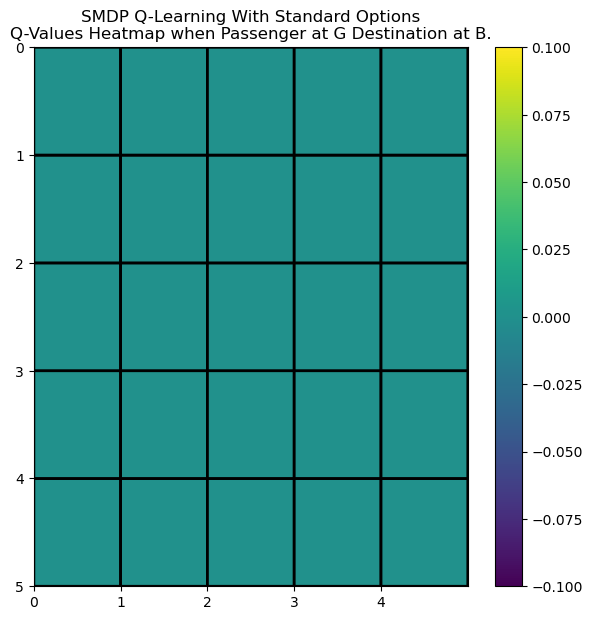

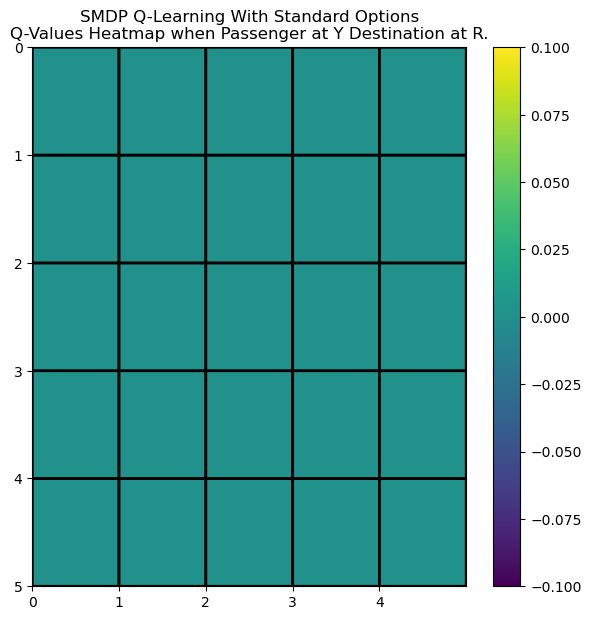

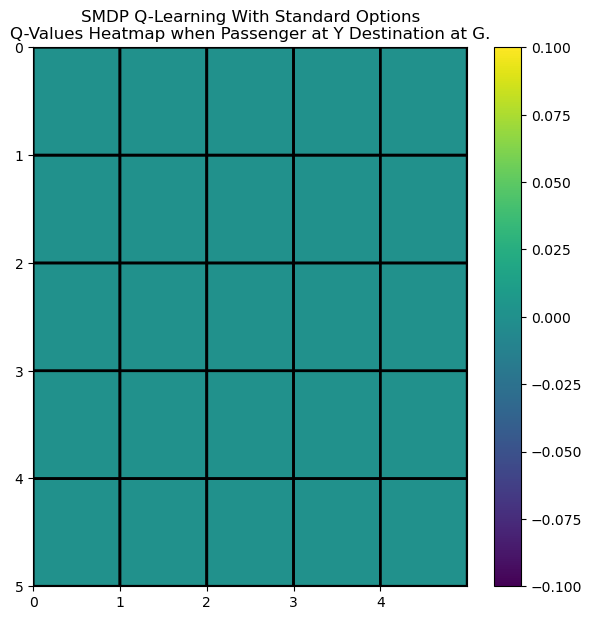

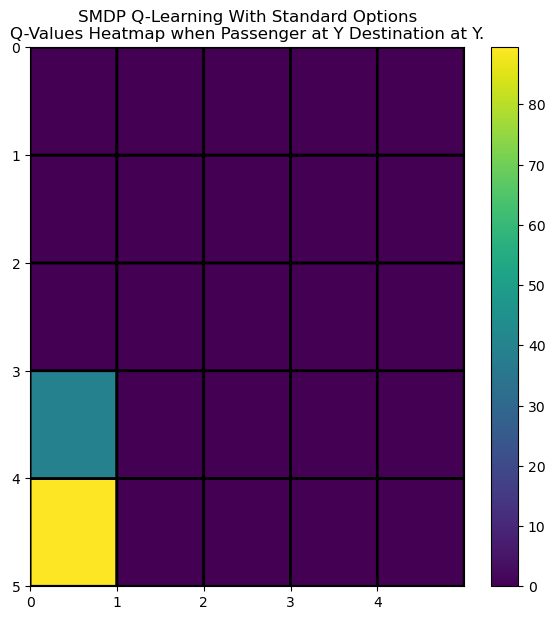

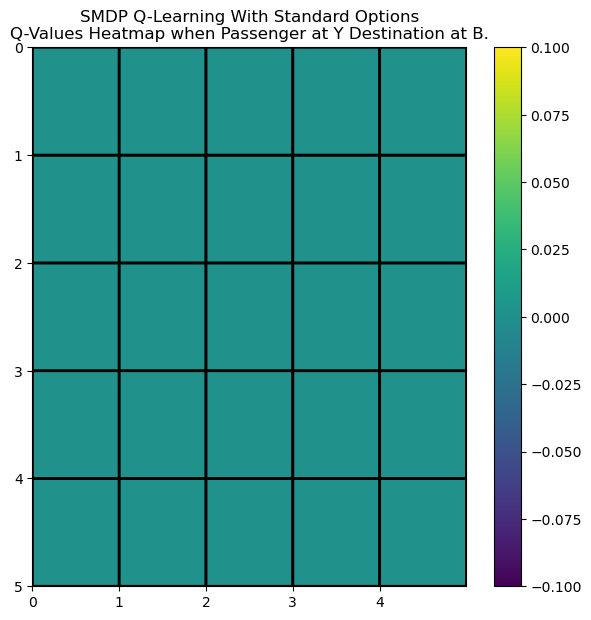

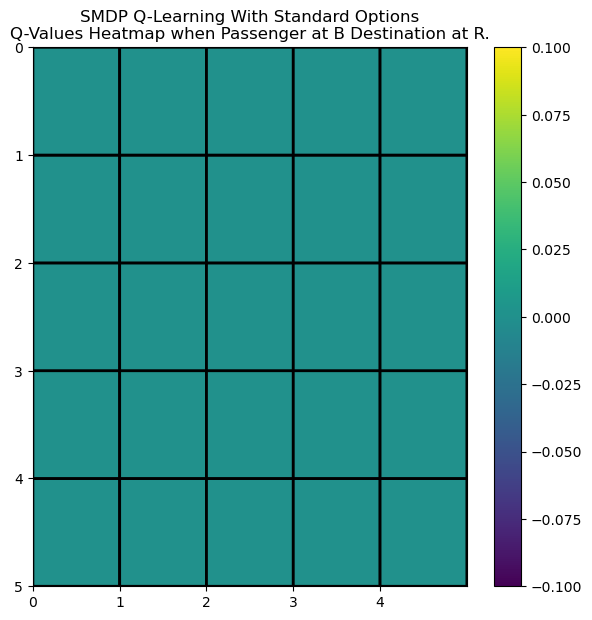

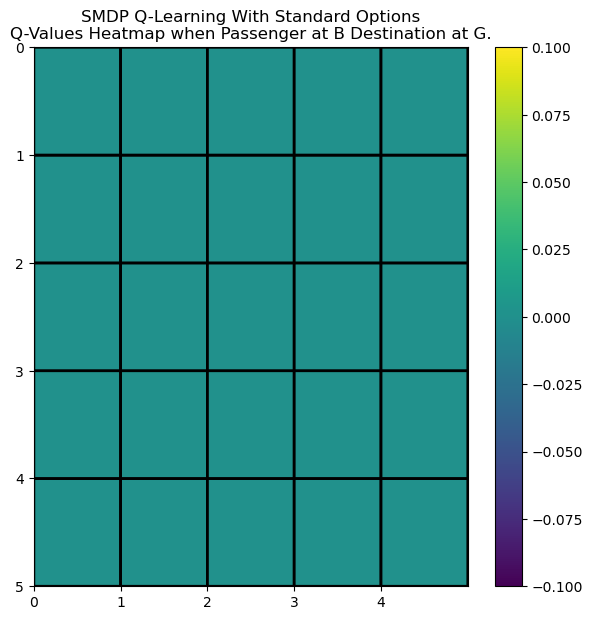

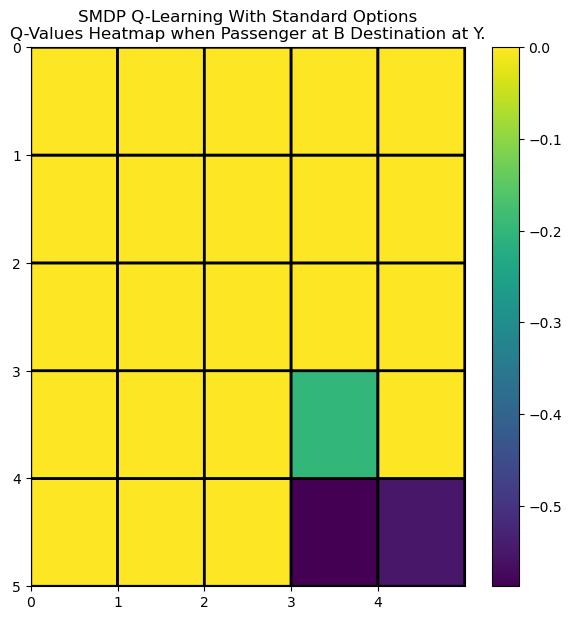

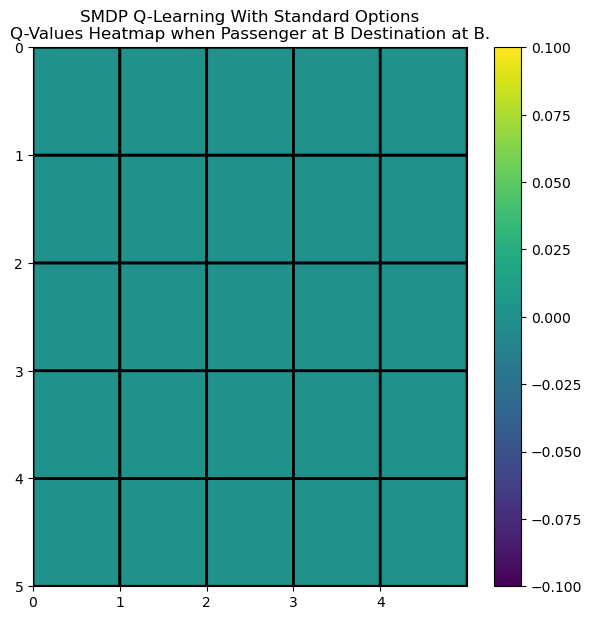

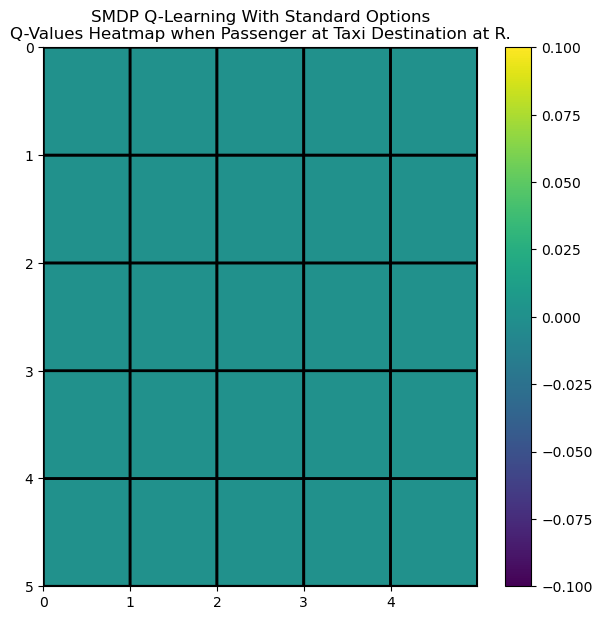

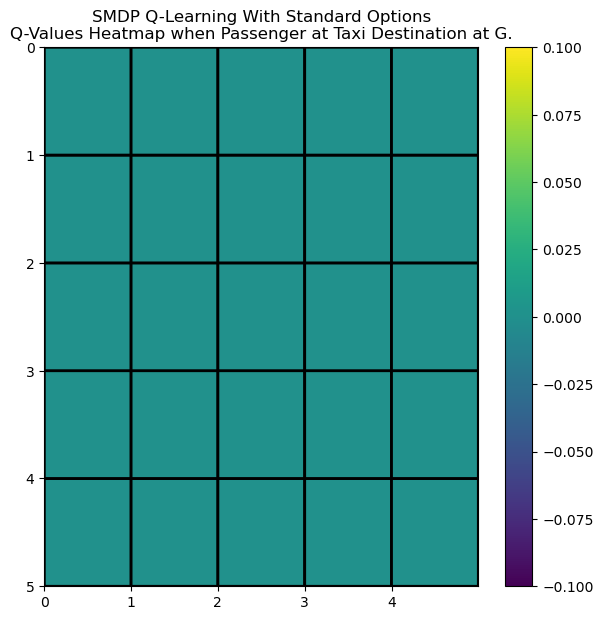

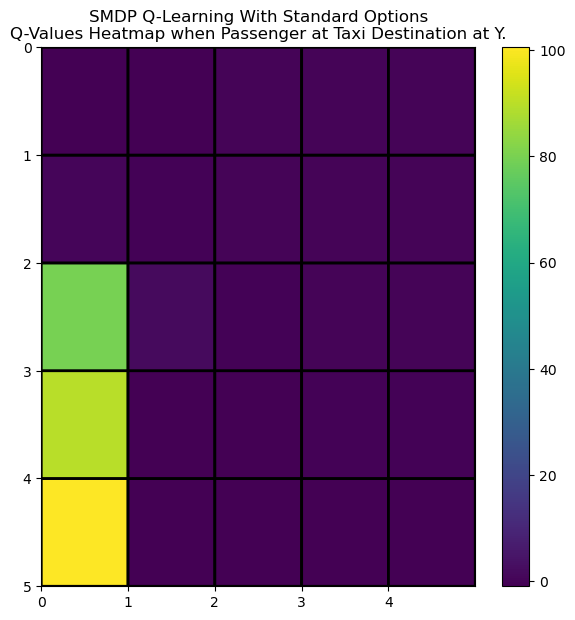

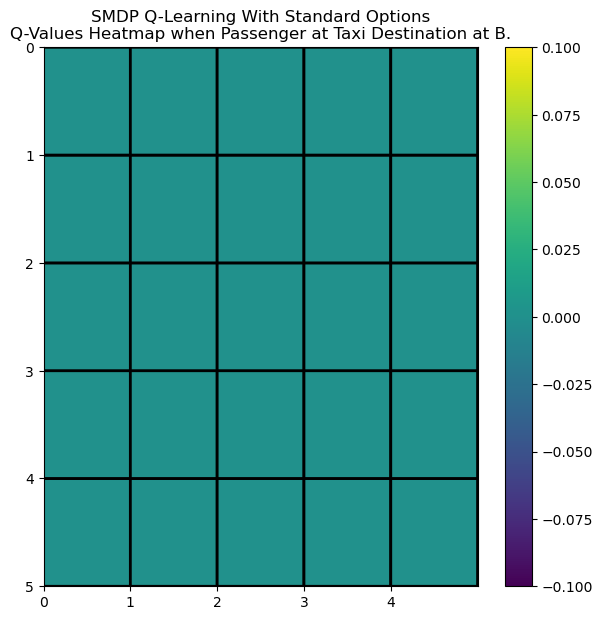

In [9]:
## Train for Standard Options
seed = 76
non_primitive_options = 4
initialization = "zeros"
pick_np_only = False
deterministic_options = 1

agent = OneStepSMDP_Qlearning(initialization=initialization,non_primitive_options=non_primitive_options,seed=seed,pick_np_only = pick_np_only,deterministic_options=deterministic_options)
agent.train(alpha = 0.2,max_episodes=200,max_episode_len = 200,eps_start = 0.25,eps_decay = 0.995,eps_end = 0.001,plotting=True,use_amask=False,option_timeout_cutoff=9)


In [6]:
"""

points:

1) det vs non-det options [det : greedy wrt current q]. det did better, plausibly because it reduced stochasticity in learning
2) e-greedy with decay is the policy to choose options, but non primitive options executed deterministically.
3) Amask is to just try out how the environment behaves, but it was found that masking hinderend learning. It was better to allow the options and let the environment learn that they are bad.
4) "perform_option" is capable of executing all the options. It is because only the termination condition of options are different.
4.1) The possiblity of a "timeout" while executing an option is what makes it semi-markov. Its an added power and flexibility. This is incorportated as cutoff.
5) Seed was fixed for numpy random generators
6) But env.reset(seed = seed), fixes the start state of every episode, hence leads to neat and clean reward plot, but fails to learn to behave in the (S)MDP, 
    this is evident from the Q-value heatmaps. Because it learned the Q-values corresponding to the start state, i.e a fixed passenger start location and desitination. As the q values were zero for all the other plots

    because, the taxi may be present in any state and there are 500 possible states. So It was a concious choice, to not set the seed in the evironment while reseting the environment.
    Because of this the convergence naturally takes more epochs, but now the q-values are learnt for all passenger start-destination pairs.

7) We may see reward spikes even after a few thousand episodes, this may happen if the epsiode starts at an unseen state. This is not surprising, but in fact it is good for learning and is the motivation to have 8000 epochs.


- regarding choosing np_only

Reg Inferences:

    - intiialization vs algo
    - Spread of Q-vals
    - on avg. 20 steps when env.reset(seed=seed), so for 500 states x500 ~= 10000 epochs, to learn for all states. But RL is okay to not know well about rarely visited states. So 8000 was chosen, considering time to run.


"""

'\n\npoints:\n\n1) det vs non-det options [det : greedy wrt current q]. det did better, plausibly because it reduced stochasticity in learning\n2) e-greedy with decay is the policy to choose options, but non primitive options executed deterministically.\n3) Amask is to just try out how the environment behaves, but it was found that masking hinderend learning. It was better to allow the options and let the environment learn that they are bad.\n4) "perform_option" is capable of executing all the options. It is because only the termination condition of options are different.\n4.1) The possiblity of a "timeout" while executing an option is what makes it semi-markov. Its an added power and flexibility. This is incorportated as cutoff.\n5) Seed was fixed for numpy random generators\n6) But env.reset(seed = seed), fixes the start state of every episode, hence leads to neat and clean reward plot, but fails to learn to behave in the (S)MDP, \n    this is evident from the Q-value heatmaps. Becau

In [36]:
agent.env.unwrapped.locs[2] == agent.get_coordinates(402)[:2]

True

In [9]:
s = agent.env.reset(seed = 76)[0]
print(s)
agent.get_coordinates(s)

402


(4, 0, 0, 2)

In [11]:
s = agent.env.reset(seed = 23)[0]
print(s)
agent.get_coordinates(s)

346


(3, 2, 1, 2)

In [13]:
s = agent.env.reset(seed = 15)[0]
print(s)
agent.get_coordinates(s)

344


(3, 2, 1, 0)

In [17]:
s = agent.env.reset(seed = 64)[0]
print(s)
agent.get_coordinates(s)

469


(4, 3, 2, 1)

In [7]:
"""
Dry run over the code once again.

Complete reading SMDP planning and also mahadev's paper. Also the intra-options paper.

=>See tutorial

Dry run over the code once.

=> All good : Hyperparameter tuning.

"""

"\nDry run over the code once again.\n\nComplete reading SMDP planning and also mahadev's paper. Also the intra-options paper.\n\n=>See tutorial\n\nDry run over the code once.\n\n=> All good : Hyperparameter tuning.\n\n"

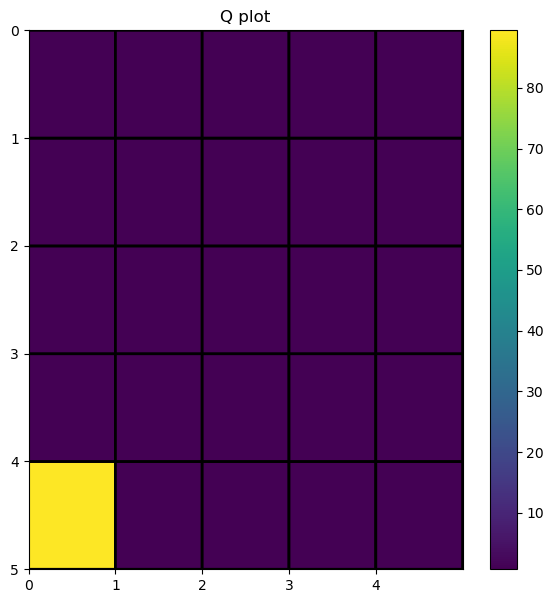

In [69]:
passenger_loc = 2
destination = 2

Q_viz = np.zeros((5,5,agent.option_space))

for i in range(5):
    for j in range(5):
        state_q_vals = agent.env.unwrapped.encode(i,j,passenger_loc,destination)
        Q_viz[i,j] = agent.Q[state_q_vals]


agent.plot_Q(Q_viz)

In [64]:
agent.env.reset(seed=23)

(346, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})

In [ ]:
env.re

In [ ]:
"""
Repo(rt)

"""

### Algorithm/Approach:

1. Reset the environment
2. At every step pick an option (from pool of primitive and non-primitive actions, possible in that state - Subject to initial states of that option).
3. Option picked using e-greedy over the Q(S,.).
4. If a non-primitive option is picked, complete it to a termination state, or truncate the episode, which ever happens first. Along the option use e-greedy to pick the primitive actions.
5. repeat for multiple episodes till convergence (or max episodes).

gamma = 0.9 is used everywhere.